In [1]:
import numpy as np
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import random


data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [2]:
list(speech_data)

['wav_vals', 'label_vals']

In [3]:
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [4]:
temp = []
for i in speech_data['wav_vals']:
    temp.append(wav2spec(i))
new_speech_data = np.array(temp)

In [5]:
new_speech_data.shape

(50620, 130, 126)

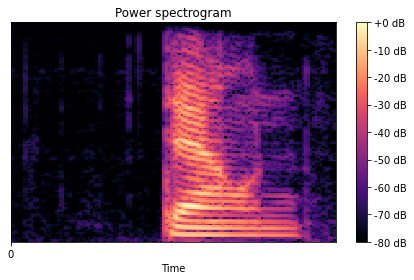

In [6]:
# spectrogram을 시각화
librosa.display.specshow(librosa.amplitude_to_db(new_speech_data[0], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [7]:
# 구분해야 할 Data Label list
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [8]:
# Label Data indexing
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

In [9]:
# 사이킷런의 split 함수를 이용하여 데이터 분리
from sklearn.model_selection import train_test_split

sr = 16380
train_wav, test_wav, train_label, test_label = train_test_split(new_speech_data, 
                                                                label_data, 
                                                                test_size=0.2,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])

[[[8.76863194e+00 1.04281816e+01 1.19565868e+01 ... 1.37690771e+00
   1.16853225e+00 1.01500821e+00]
  [3.37337446e+00 5.62801266e+00 6.80112553e+00 ... 7.31489956e-01
   6.18390501e-01 4.08805400e-01]
  [1.31007767e+00 7.87168145e-01 7.48007119e-01 ... 3.15492488e-02
   7.71402046e-02 1.30744055e-01]
  ...
  [2.71401349e-02 1.40413390e-02 6.31397532e-04 ... 1.17263442e-03
   2.28823181e-02 4.36179712e-02]
  [2.69670803e-02 1.34930070e-02 6.52132439e-05 ... 1.68686573e-04
   2.37915702e-02 4.54995334e-02]
  [2.68023070e-02 1.36005785e-02 3.57264616e-05 ... 1.76051428e-04
   2.38037575e-02 4.58844490e-02]]

 [[5.38483364e-05 8.35494546e-04 2.67577870e-03 ... 1.74284424e-03
   1.68281418e-04 7.02001853e-04]
  [4.87871948e-05 7.61616975e-04 1.91207184e-03 ... 6.87247782e-04
   1.16882368e-03 1.56427058e-03]
  [3.47188252e-05 5.78907609e-04 5.08654921e-04 ... 1.48369290e-03
   1.70847808e-03 1.67427736e-03]
  ...
  [1.59584047e-07 1.85412443e-06 1.79100891e-06 ... 7.00896067e-07
   5.24589

In [10]:
# 데이터셋 확인
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

# Hyper-parameter Setting
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models_skip_connect/wav'

checkpoint_dir

train data :  (40496, 16380, 1)
train labels :  (40496,)
test data :  (10124, 16380, 1)
test labels :  (10124,)


'/home/ssac10/aiffel/speech_recognition/models_skip_connect/wav'

In [11]:
# One-hot Encoding
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [12]:
# Dataset 함수 구성
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 16380, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 16380, 1), (None, 12)), types: (tf.float32, tf.float32)>


In [13]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16380, 1)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16380, 32)    320         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 16380, 32)    9248        conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 8190, 32)     0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [14]:
# optimizer 설정
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [15]:
# callback 설정
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [16]:
# 모델 훈련
history_wav = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1265/1265 [==============================] - ETA: 0s - loss: 0.8736 - accuracy: 0.7183
Epoch 00001: val_loss improved from inf to 0.52934, saving model to /home/ssac10/aiffel/speech_recognition/models_skip_connect/wav
1265/1265 [==============================] - 308s 243ms/step - loss: 0.8736 - accuracy: 0.7183 - val_loss: 0.5293 - val_accuracy: 0.8317
Epoch 2/10
1265/1265 [==============================] - ETA: 0s - loss: 0.3504 - accuracy: 0.8963
Epoch 00002: val_loss improved from 0.52934 to 0.39600, saving model to /home/ssac10/aiffel/speech_recognition/models_skip_connect/wav
1265/1265 [==============================] - 310s 245ms/step - loss: 0.3504 - accuracy: 0.8963 - val_loss: 0.3960 - val_accuracy: 0.8795
Epoch 3/10
1265/1265 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.9483
Epoch 00003: val_loss improved from 0.39600 to 0.32967, saving model to /home/ssac10/aiffel/speech_recognition/models_skip_connect/wav
1265/1265 [====================

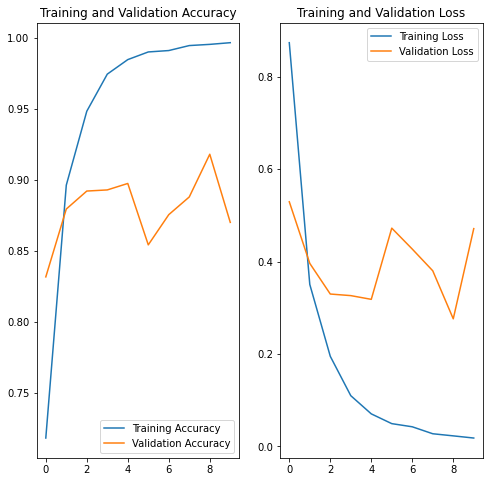

In [21]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
# checkpoint callback 함수에서 저장한 weight 불러오기
model_wav_skip.load_weights(checkpoint_dir)

In [19]:
# test 데이터와 비교
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

317/317 [==============================] - 32s 102ms/step - loss: 0.2761 - accuracy: 0.9180
loss value: 0.276
accuracy value: 91.8017%


In [20]:
# 예측 데이터
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(16380,), rate=16380)

# 실제 데이터가 맞는지 확인
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

label :  off
y_pred: off(Correct!)
